In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans

from descriptor_calculator import * # Module for molecular fingerprint & descriptor calculations
from training import * # Module for model training and cross validation
from rdkit.Chem import Draw # Visualize representative test set structures

## Load data

In [2]:
# Load and clean raw data
df_raw = pd.read_csv('./data/data.csv')

# Filter out rows without Max_LCAP values
df = df_raw[df_raw['Max_LCAP'].notna()]
df = df.reset_index(drop=True)
df['Round_Number'] = df['Round_Number'].apply(lambda x: int(str(x)[-1]))
df.head()

,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP
0,4897720,CCCCn1ccnc1,0,0
1,18461035,CC(=O)c1ocnc1,0,72
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87
3,16916940,Brc1ccc(cc1)c2cncs2,0,78
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0


In [3]:
# Load descriptors calculated using internal platform
mix_desc_df = pd.read_csv('./data/mix_des.csv')
mix_desc_df = mix_desc_df.dropna(axis=1)
mix_features = mix_desc_df.columns.tolist()[1:]
print(f'There are {len(mix_features)} imported MIX features from internal platform.')

# Merge the mix descriptors with the main dataframe on 'ID_Number'
df = df.merge(mix_desc_df, on='ID_Number')
df.head()

There are 3747 imported MIX features from internal platform.


,ID_Number,Canonical_Smiles,Round_Number,Max_LCAP,BrX1sp3BrX1sp305,CX1sp3BrX1sp303,CX1sp3BrX1sp304,CX1sp3BrX1sp305,CX1sp3BrX1sp306,CX1sp3BrX1sp307,...,X4sp3ClX1sp311,X4sp3NX2sp205,X4sp3NX2sp206,X4sp3NX2sp207,X4sp3NX2sp209,X4sp3NX2sp211,X4sp3NX3sp305,X4sp3OX1sp211,X4sp3OX2sp303,X4sp3SX2sp304
0,4897720,CCCCn1ccnc1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18461035,CC(=O)c1ocnc1,0,72,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1762470,Fc1ccc(cc1)c2ocnc2,0,87,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16916940,Brc1ccc(cc1)c2cncs2,0,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1040111,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Load descriptors calculated from DFT-optimized geometries
df_dft = pd.read_csv('./data/data_dft.csv')

# Define DFT features
dft_features = [
    'N (eV)', 'HOMO (eV)', 'LUMO (eV)', 'Gap (eV)', 
    'Omega', 'dqG', 'Bmin', 'Bmax', 
    'L', 'PMI_X', 'PMI_Y', 'PMI_Z'
]

print(f'There are {len(dft_features)} imported DFT features.')

There are 12 imported DFT features.


In [5]:
# Calculate molecular fingerprints and descriptors
rdkit_desc = calc_rdkit_desc(df)  # Compute RDKit descriptors
rdkit_fp = calc_rdkit_fp(df, radius=2, nBits=2048)  # Compute molecular fingerprints

# Combine descriptors and fingerprints into a single dataframe
desc_fp = rdkit_desc.join(rdkit_fp)

# Optionally save combined dataframe of descriptors and fingerprints to a CSV file
#desc_fp.to_csv('./data/rdkit_desc_fp.csv', index=False)

rdkit_features = desc_fp.columns.tolist()

In [6]:
# Combine all features into a single dataframe
df_clean = pd.concat(
    [
        df[['Canonical_Smiles', 'Round_Number', 'Max_LCAP', 'ID_Number'] + mix_features], 
        desc_fp
    ], 
    axis=1
)

# Merge on 'SMILES' to include DFT features
df_clean = df_clean.merge(df_dft[dft_features + ['Canonical_Smiles']], on='Canonical_Smiles')

# Optionally save all features to a CSV file
#df_clean.to_csv('all_features.csv', index=False)

df_clean.head()

,Canonical_Smiles,Round_Number,Max_LCAP,ID_Number,BrX1sp3BrX1sp305,CX1sp3BrX1sp303,CX1sp3BrX1sp304,CX1sp3BrX1sp305,CX1sp3BrX1sp306,CX1sp3BrX1sp307,...,LUMO (eV),Gap (eV),Omega,dqG,Bmin,Bmax,L,PMI_X,PMI_Y,PMI_Z
0,CCCCn1ccnc1,0,0,4897720,0,0,0,0,0,0,...,1.55,9.23,0.018667,66.200171,1.71,7.91,5.10,15.11284,119.05900,132.05374
1,CC(=O)c1ocnc1,0,72,18461035,0,0,0,0,0,0,...,-0.79,7.93,0.052357,52.809485,1.74,4.66,7.15,17.18341,52.33765,69.00428
2,Fc1ccc(cc1)c2ocnc2,0,87,1762470,0,0,0,0,0,0,...,-0.34,7.07,0.039040,56.561304,1.65,6.65,8.40,23.60169,178.26557,201.86727
3,Brc1ccc(cc1)c2cncs2,0,78,16916940,0,0,0,0,0,0,...,-0.88,6.60,0.048713,55.462471,1.71,5.40,10.80,29.47762,386.11696,415.59459
4,Fc1cc(ccc1[C@@H]2CCc3cncn23)C#N,0,0,1040111,0,0,0,0,0,0,...,-0.95,6.63,0.050420,63.966738,1.78,7.98,5.95,87.74469,306.39359,323.60486


## Calculate permutation feature importance

### Defining a representative test set using k-means clustering for PFI analysis 

In [7]:
# For representative test set generation, define the round for clustering
r = 7 # Use all data for clustering to choose a representative test set for PFI calculation
df_to_cluster = df_clean[df_clean.Round_Number <= r]

# Determine the number of clusters
n_clusters = int(0.2 * len(df_to_cluster))

# Prepare features for K-means clustering
X = df_to_cluster[rdkit_features]

# Perform K-means clustering
k_means = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=0)
kmeans_y_pred = k_means.fit_predict(X)

df_all_clusters = pd.DataFrame({
    'smiles': df_to_cluster.smiles,
    'KMeansCluster': kmeans_y_pred
})

# Select ligands closest to the centroid of each cluster
selected_ligands = []
for n in range(n_clusters):
    # Find all members that belong to cluster n
    members = df_all_clusters[df_all_clusters['KMeansCluster'] == n].index.tolist()
    
    # Find the closest member to the center of cluster n
    closest_ind = pairwise_distances_argmin_min(k_means.cluster_centers_, X.iloc[members])[0][n]
    selected_ligands.append(members[closest_ind])

# Mark selected ligands as centroids
df_all_clusters['Centroid'] = 'No'
for i in selected_ligands:
    df_all_clusters.at[i, 'Centroid'] = 'Yes'

# Fill missing values in the 'Centroid' column
df_all_clusters['Centroid'].fillna('No', inplace=True)

# Create training and testing DataFrames
train_df = df_all_clusters[df_all_clusters['Centroid'] == 'No'].merge(df_clean, on='smiles')
kmeans_test_df = df_all_clusters[df_all_clusters['Centroid'] == 'Yes'].merge(df_clean, on='smiles')

Total run time is 2.80 seconds


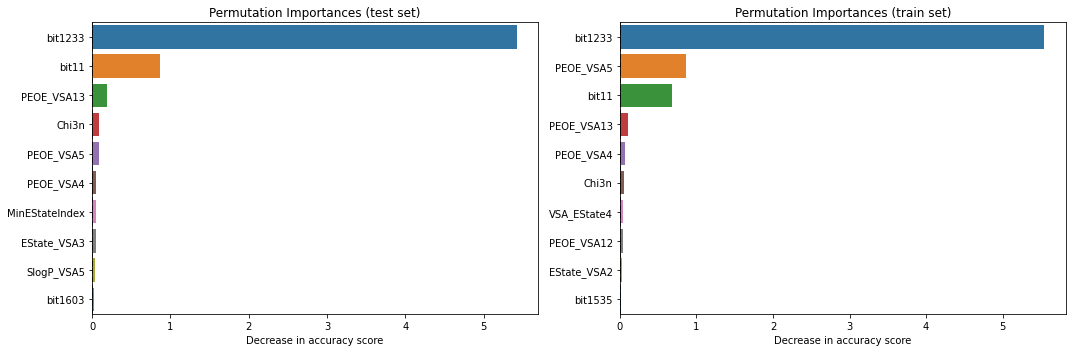

In [8]:
# Define features and model for PFI
features = rdkit_features
rf = RandomForestRegressor()

# Train model and evaluate performance
trained_rf, performance, preds = model_training(
    data=train_df, 
    model=rf, 
    split_method=None, # Use k-means representative test set instead
    descriptors=features, 
    test_df=kmeans_test_df
)

# Prepare training and testing data
X_test, y_test = kmeans_test_df[features], kmeans_test_df['Max_LCAP']
X_train, y_train = train_df[features], train_df['Max_LCAP']

# Calculate permutation importance for test set
result_test = permutation_importance(
    trained_rf, X_test, y_test, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=2, 
    scoring='neg_mean_absolute_error'
)

# Sort feature importances for test set
sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test],
)

# Calculate permutation importance for training data
result_train = permutation_importance(
    trained_rf, X_train, y_train, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=2, 
    scoring='neg_mean_absolute_error'
)

# Sort feature importances for training set
sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X_train.columns[sorted_importances_idx_train],
)

# Uncomment to save the importances to CSV
# importances_test.to_csv('./data/PFI_results/mix_features_PFI_test.csv', index=False)
# importances_train.to_csv('./data/PFI_results/mix_features_PFI_train.csv', index=False)

# Calculate and sort the average importances
pfi_test = importances_test.mean(axis=0).sort_values(ascending=False)[:10]
pfi_train = importances_train.mean(axis=0).sort_values(ascending=False)[:10]

# Plotting
f, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(y=pfi_test.index, x=pfi_test, ax=axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

sns.barplot(y=pfi_train.index, x=pfi_train, ax=axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

plt.show()

### Using Round 7 compounds as test set for PFI analysis 

Total run time is 6.58 seconds


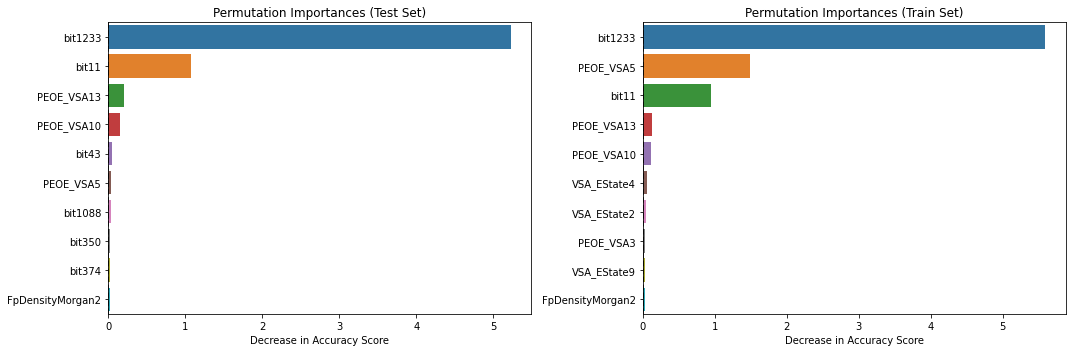

In [9]:
# Define features and model for PFI
features = rdkit_features
rf = RandomForestRegressor()

# Train model using the provided function
trained_rf, performance, preds = model_training(
    data=train_df,
    model=rf,
    split_method='round', # Use latest round of compounds as test set
    descriptors=features,
    test_df=None # Change to kmeans_test_df representative set for splitting data using k-means clustering 
)


# Prepare test and training data
X_test, y_test = kmeans_test_df[features], kmeans_test_df['Max_LCAP']
X_train, y_train = train_df[features], train_df['Max_LCAP']

# Calculate permutation importance for test data
result_test = permutation_importance(
    trained_rf, 
    X_test, 
    y_test, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=2, 
    scoring='neg_mean_absolute_error'
)

# Prepare sorted importances dataframe for test data
sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_test.columns[sorted_importances_idx_test]
)

# Calculate permutation importance for training data
result_train = permutation_importance(
    trained_rf, 
    X_train, 
    y_train, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=2, 
    scoring='neg_mean_absolute_error'
)

# Prepare sorted importances dataframe for training data
sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X_train.columns[sorted_importances_idx_train]
)

# Optionally save results to CSV (uncomment if needed)
# importances_test.to_csv('./data/PFI_results/mix_features_PFI_test.csv', index=False)
# importances_train.to_csv('./data/PFI_results/mix_features_PFI_train.csv', index=False)

# Calculate and sort average permutation importances
pfi_test = importances_test.mean(axis=0).sort_values(ascending=False)[:10]
pfi_train = importances_train.mean(axis=0).sort_values(ascending=False)[:10]

# Create bar plots for test and train permutation importances
f, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Test Set
sns.barplot(y=pfi_test.index, x=pfi_test, ax=axs[0])
axs[0].set_title("Permutation Importances (Test Set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in Accuracy Score")

# Plot for Train Set
sns.barplot(y=pfi_train.index, x=pfi_train, ax=axs[1])
axs[1].set_title("Permutation Importances (Train Set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in Accuracy Score")

plt.tight_layout()
plt.show()

### Calculate percentage change in MAE

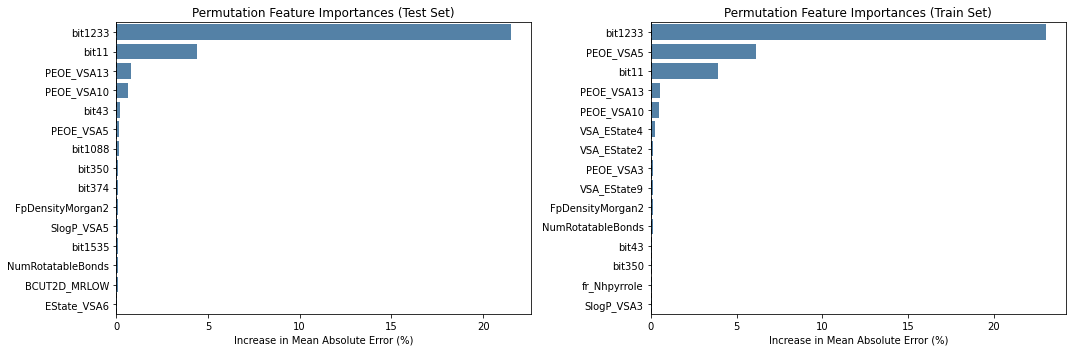

In [10]:
# Calculate permutation feature importances as a percentage of Mean Absolute Error (MAE)
mae_value = performance['mae']

# For test set
pfi_test = 100 * importances_test.mean(axis=0) / mae_value
pfi_test = pfi_test.sort_values(ascending=False)[:15]  # Top 15 features

# For training set
pfi_train = 100 * importances_train.mean(axis=0) / mae_value
pfi_train = pfi_train.sort_values(ascending=False)[:15]  # Top 15 features

# Create bar plots for test and train permutation importances
f, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for test Set
sns.barplot(y=pfi_test.index, x=pfi_test, ax=axs[0], color='steelblue')
axs[0].set_title("Permutation Feature Importances (Test Set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Increase in Mean Absolute Error (%)")
axs[0].figure.tight_layout()

# Plot for train Set
sns.barplot(y=pfi_train.index, x=pfi_train, ax=axs[1], color='steelblue')
axs[1].set_title("Permutation Feature Importances (Train Set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Increase in Mean Absolute Error (%)")
axs[1].figure.tight_layout()
plt.show()

### Viewing important fingerprint bits 

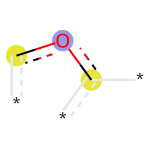

In [11]:
# Specify molecular fingerprint bit of interest
feature = 'bit1233'
bit_no = int(feature[3:])  # Extract bit number

# Retrieve SMILES of first molecular entity that has specified fingerprint bit set
smi = df_clean[df_clean[feature] == 1.0]['smiles'].tolist()[0]

# Convert SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(smi)

# Generate molecular fingerprint and associated bit info
bit_info = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, bitInfo=bit_info)
Draw.DrawMorganBit(mol, bit_no, bit_info)